## Regrassion problome - Energy demand

### predicting next day energy demand 

In [1]:
#Final Assighnment Intro To Data-Science

#Part-3-2: Liniar-Regrassion

#Name: Israel Yaacobovich

#ID: 212403679

In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import linear_model
from sklearn.dummy import DummyRegressor

### First look

In [20]:
#loading the data
df = pd.read_csv(r'C:\Users\ישראל\DS\energy-demand-spain-data-set\energy_dataset.csv',  parse_dates = ['time'])
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [21]:
#these are just filled with zeroes
df.drop(['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat',
                'generation geothermal', 'generation marine', 'generation wind offshore'], axis = 1, inplace = True)

In [121]:
df.shape

(35064, 23)

In [15]:
#checking for missing values
df.isnull().sum().sum()

70420

In [16]:
#what precantage of each column is missing
df.isnull().sum()/df.shape[0]  *100

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation nuclear                               0.048483
generation other                                 0.051335
generation other renewable                       0.051335
generation solar                                 0.051335
generation waste                                 0.054187
generation wind onshore                          0.051335
forecast solar day ahead                         0.000000
forecast wind 

In [22]:
#These are completley empty
df.drop(['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'], axis = 1, inplace = True)

In [5]:
#after these, the variable with the most missing values is
#the 'total load actual', its still only 1% missing but since its
#the target variable Ill put some effort

#serching for strongly corrlated feachers
df.corr()['total load actual'].nlargest(5)

total load actual                   1.000000
total load forecast                 0.995139
generation fossil gas               0.548913
generation fossil oil               0.497089
generation hydro water reservoir    0.479481
Name: total load actual, dtype: float64

In [23]:
#'total load forecast' is  bacicly someonelses prediction model
#so I wolnt use it, Ill get rid off it soon
#Ill use pandas.groupby method to fill the missing values
#with avarges related to the next most corrlated feature

In [24]:
#Categorasing to different levels with a new column
#I will use those to mark the missing data in the sunshine column
#Than Ill replace the marks with a corasponding avarge
#I use negtive numbers so I wolnt chnge the origonal data

df['generation fossil gas level'] = np.round(df['generation fossil gas'] /-1000 - 1)

#the avarge for each group
g = df.groupby('generation fossil gas level')['total load actual'].mean()
g

generation fossil gas level
-21.0    37798.250000
-20.0    35944.666667
-19.0    36597.550000
-18.0    35641.230769
-17.0    34795.187500
-16.0    34896.358209
-15.0    34464.992248
-14.0    33988.059524
-13.0    34299.235632
-12.0    33990.278146
-11.0    33653.037415
-10.0    33168.281250
-9.0     32406.457229
-8.0     31505.473157
-7.0     29845.176988
-6.0     27823.532676
-5.0     26229.971983
-4.0     26130.417023
-3.0     26616.753521
-1.0     38603.000000
Name: total load actual, dtype: float64

In [25]:
#Now Ill use this to fill the missing values
df['total load actual'].fillna(value = df['generation fossil gas level'], inplace= True)
df['total load actual'].replace(dict(g), inplace = True)
df.drop('generation fossil gas level', axis = 1, inplace = True)

df['total load actual'].isnull().sum()

13

In [ ]:
#its not 0 because the 'generation fossil gas level' feature
#had some null values itself

In [26]:
df.dropna(how = 'any', axis = 0, inplace = True)
df = df.reset_index(drop = True)

In [8]:
df.shape

(35041, 21)

In [27]:
#creating more comfertubale time-messurement columns 

df['time'] = pd.to_datetime(df['time'], utc = True)
df['Year'] = df['time'].dt.year
df['Month'] = df['time'].dt.month
df['Day'] = df['time'].dt.day
df.drop(['time'], axis = 1, inplace = True)

In [9]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'Year', 'Month', 'Day'],
      dtype='object')

In [28]:
#deviding the different variables in to groups

A = ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore']
B = ['forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead','price actual']
C = ['Year', 'Month', 'Day']

### Exploring the data

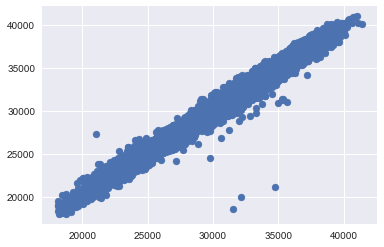

In [127]:
plt.scatter(df['total load forecast'],df['total load actual'])
plt.show()

In [29]:
#this is kinda like cheating its bacicaly just some other model
df.drop('total load forecast', axis = 1, inplace = True)

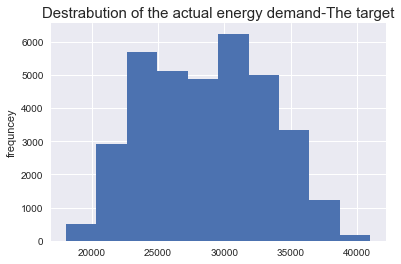

In [129]:
plt.hist(df["total load actual"])
plt.title('Destrabution of the actual energy demand-The target', fontsize = 15)
plt.ylabel('frequncey')
plt.show()

##### 'The makeup of the energy-grid -just the sources that contribute atlist 1% of the toat energy production'

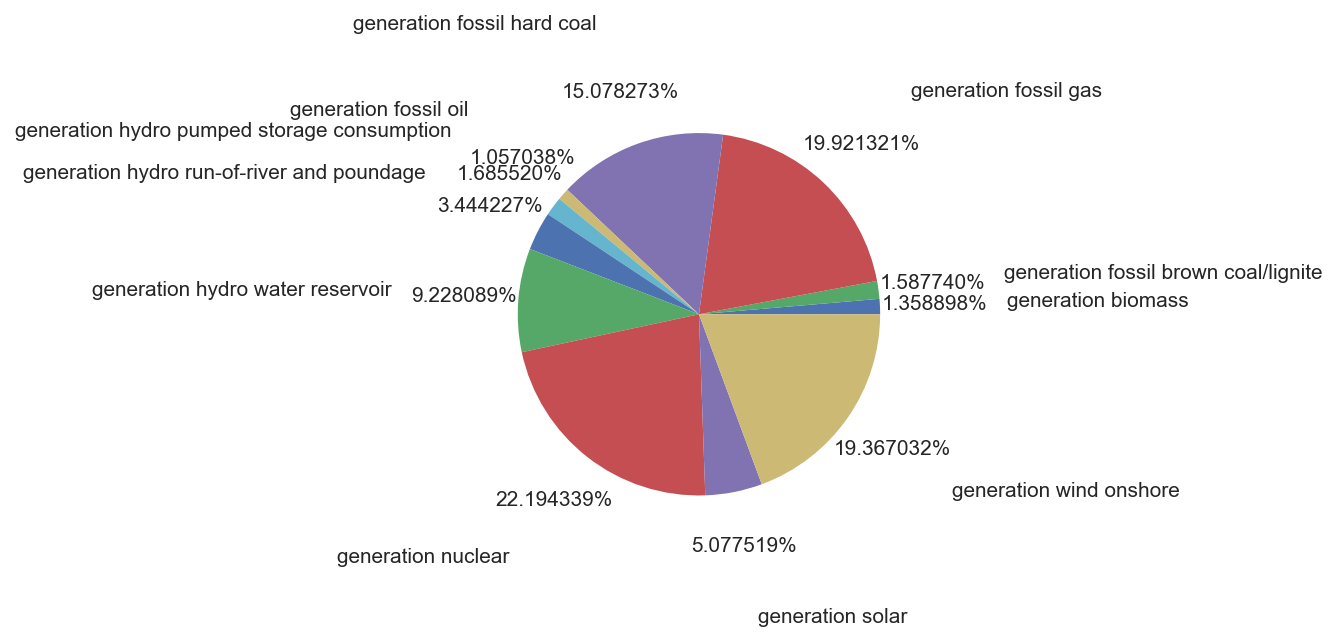

In [130]:
plt.figure(dpi = 150)
data = df[A].sum().loc[df[A].sum() > df[A].sum().sum() * 0.01]
labels = data.index
plt.pie(data, labeldistance = 1.7, labels = labels,  autopct = '%2f%%', pctdistance = 1.3)
plt.show()

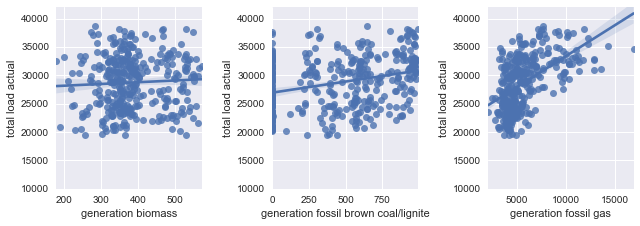

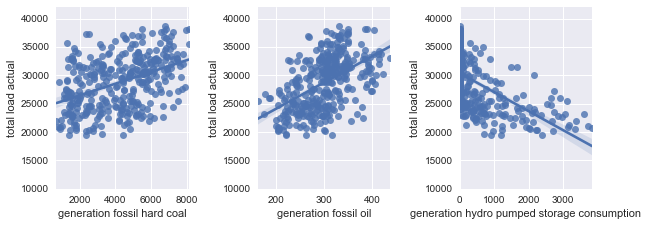

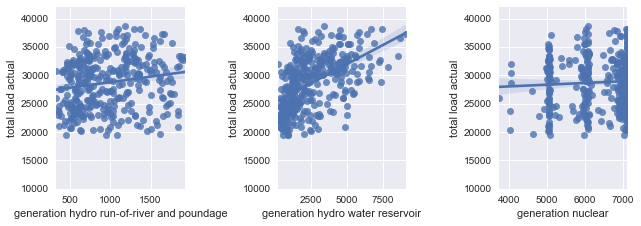

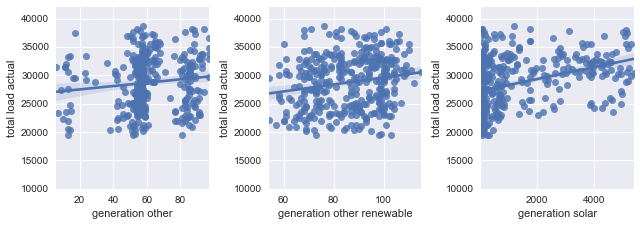

In [43]:
i = 0
while(i < 12):
    plt.figure(figsize = (9,9))
    for j in range(3):
        plt.subplot(3,3,j+1)
        plt.ylim([10000,42000])
        sns.regplot(data = df[::100], y = "total load actual", x = A[i+j])
    plt.tight_layout()
    plt.show()
    i += 3

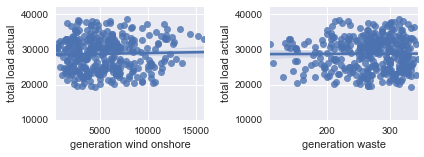

In [44]:
#leftovers

plt.subplot(2,2,1)
plt.ylim([10000,42000])
sns.regplot(data = df[::100], y = "total load actual", x = A[-1])
plt.subplot(2,2,2)
plt.ylim([10000,42000])
sns.regplot(data = df[::100], y = "total load actual", x = A[-2])

plt.tight_layout()
plt.show()

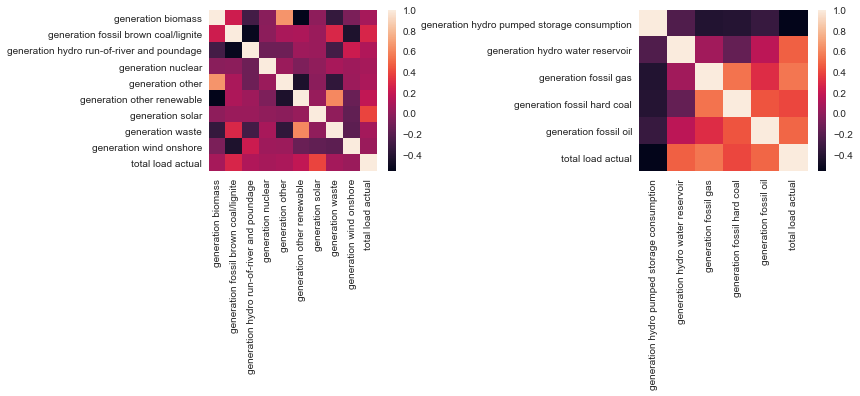

In [30]:
# looks like the folowwing features have the strongest corrolation with the target variable
prommsing = ['generation hydro pumped storage consumption','generation hydro water reservoir',
            'generation fossil gas', 'generation fossil hard coal','generation fossil oil']

#That is thee generation from fossile fules and hydro-electrical facilities
#lets check

plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
sns.heatmap(df[A + ['total load actual']].drop(prommsing, axis = 1).corr())
plt.subplot(2,2,2)
sns.heatmap(df[prommsing + ['total load actual']].corr())
plt.tight_layout()
plt.show()

In [ ]:
#Indeed the bottom row which is the target variable, in the first corralation matrix has more moderate
#colors than the second(weaker corrlations) 

In [75]:
B

['forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load forecast',
 'total load actual',
 'price day ahead',
 'price actual']

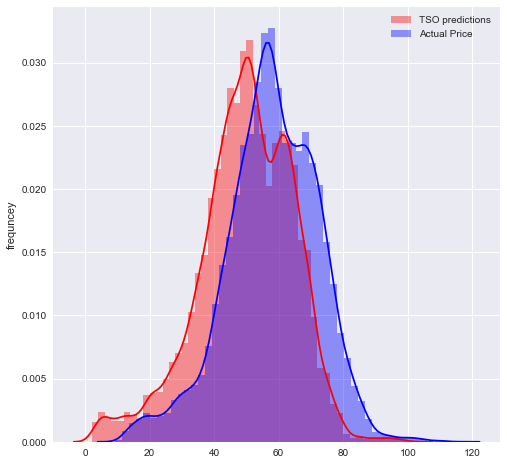

In [13]:
plt.figure(figsize = (8,8))
sns.distplot(df['price day ahead'], bins=50, label='TSO predictions',color='r')
sns.distplot(df['price actual'], bins=50, label='Actual Price',color='b')
plt.xlabel('')
plt.ylabel('frequncey')
plt.legend()
plt.show()

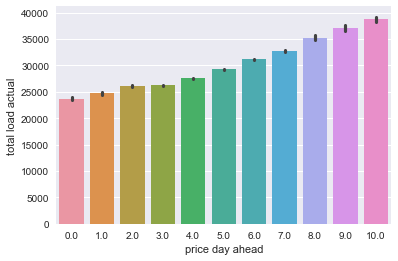

In [16]:
#now lets see the relationship between the target and the feacher 'price day ahead'

sns.barplot(df['price day ahead']//10,df['total load actual'])
plt.show()

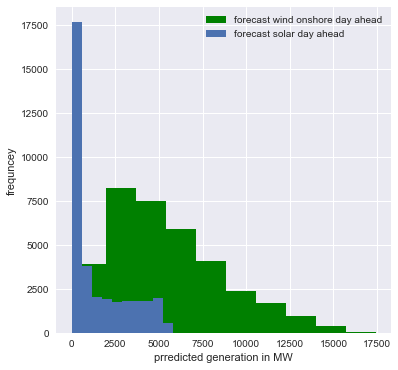

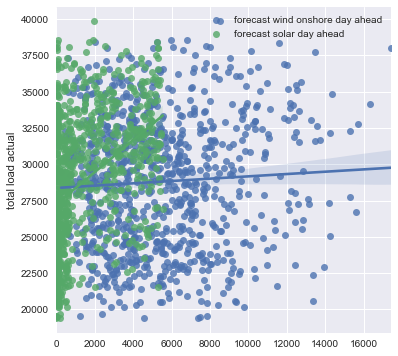

In [22]:
labels = ['forecast wind onshore day ahead', 'forecast solar day ahead']

plt.figure(figsize = (6,6))
plt.hist(df[labels[0]],label = labels[0],  color = 'g')
plt.hist(df[labels[1]],label = labels[1])
plt.xlabel('prredicted generation in MW')
plt.ylabel('frequncey')
plt.legend()
plt.show()
plt.figure(figsize = (6,6))
sns.regplot(data = df[::40], x = 'forecast wind onshore day ahead', y = 'total load actual', label = labels[0])
sns.regplot(data = df[::40], x = 'forecast solar day ahead', y = 'total load actual', label = labels[1])
plt.xlabel('')
plt.legend()
plt.show()

In [74]:
C

['Year', 'Month', 'Day']

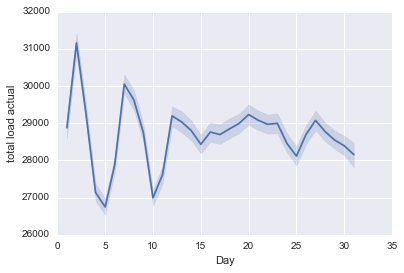

In [71]:
sns.lineplot(df['Day'] ,df["total load actual"])
plt.show()

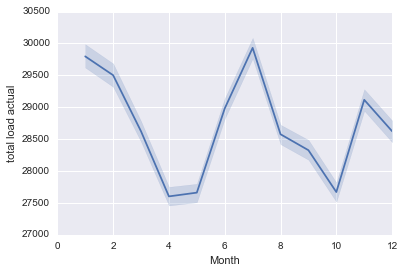

In [72]:
sns.lineplot(df['Month'] ,df["total load actual"])
plt.show()

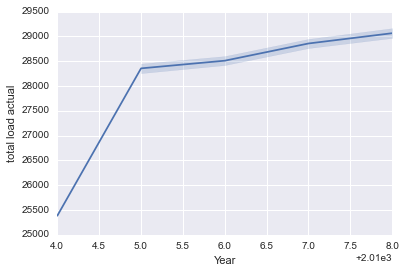

In [73]:
sns.lineplot(df['Year'] ,df["total load actual"])
plt.show()

In [31]:
#changing to string type so Ill be able to use pandas.get_dummies method

C.remove('Year')

for i in range(1,32):
    df[C] = df[C].replace({i:str(i)})
df[C].info()

dt_encoding = pd.get_dummies(df[C])
df = pd.concat([df, dt_encoding], axis = 'columns')
df = df.drop(C, axis = 1)
C = list(dt_encoding.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35041 entries, 0 to 35040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   35041 non-null  object
 1   Day     35041 non-null  object
dtypes: object(2)
memory usage: 547.6+ KB


In [32]:
#normlasing
df.Year = df.Year - 2000

### Building the model

In [33]:
s = MinMaxScaler()

cols = list(df.columns)

#using minmaxscaler to normlaize the data
df[cols[:21]] = s.fit_transform(df[cols[:21]])
df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,0.755068,0.329329,0.241789,0.576744,0.360802,0.190803,0.5255,0.195210,0.997049,0.405660,...,0,0,0,1,0,0,0,0,0,0
1,0.758446,0.328328,0.259359,0.568848,0.351893,0.203405,0.5045,0.170436,0.997049,0.405660,...,0,0,0,0,0,0,0,0,0,0
2,0.756757,0.323323,0.242438,0.548032,0.349666,0.257351,0.4865,0.140933,0.997471,0.405660,...,0,0,0,0,0,0,0,0,0,0
3,0.739865,0.254254,0.215334,0.494198,0.356347,0.332302,0.4745,0.080078,0.997330,0.405660,...,0,0,0,0,0,0,0,0,0,0
4,0.722973,0.187187,0.206150,0.459385,0.347439,0.403714,0.4765,0.074013,0.997190,0.405660,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35036,0.501689,0.000000,0.381052,0.314392,0.396437,0.000221,0.5675,0.497122,0.853309,0.594340,...,0,0,0,1,0,0,0,0,0,0
35037,0.500000,0.000000,0.361436,0.306975,0.387528,0.000221,0.5860,0.404091,0.853449,0.584906,...,0,0,0,1,0,0,0,0,0,0
35038,0.493243,0.000000,0.350654,0.289748,0.374165,0.011055,0.5740,0.291016,0.853731,0.575472,...,0,0,0,1,0,0,0,0,0,0
35039,0.494932,0.000000,0.327543,0.274315,0.363029,0.023878,0.5640,0.212582,0.853590,0.575472,...,0,0,0,1,0,0,0,0,0,0


In [34]:
def spliting(df, num):
    df2 = df.copy()
    
    workset = df2.drop(list(df.index[num:]), axis = 0)

    target = workset['total load actual']

    workset.drop('total load actual', axis = 1, inplace = True)

    test = df2[num:].drop('total load actual', axis = 1)

    test_class = df2['total load actual'][num:]
    
    return workset, target, test, test_class

In [35]:
workset, target, test, test_class = spliting(df, 34000)

In [36]:
#baceline preformance with a model that alaways predicts the avarge result, using R2 score

dummy = DummyRegressor()
dummy.fit(workset, target)
dummy.score(test, test_class)

-0.017821204189879092

In [37]:
lin = linear_model.LinearRegression()
lin.fit(workset, target)

LinearRegression()

In [38]:
y_pred = lin.predict(test)
print(metrics.mean_absolute_error(test_class, y_pred))
print(metrics.r2_score(test_class, y_pred))
print(metrics.mean_squared_error(test_class, y_pred))

0.05250423414524427
0.9049614754078275
0.004305700123698552


In [39]:
df.shape

(35041, 63)

In [40]:
#getting rid of unnesseiry fetures or even harmful ones

l = list(df.columns)

for i in range(len(l)):
    if l[i] != 'total load actual':
        df2 = df.drop(l[i], axis = 1)
    
        workset, target, test, test_class = spliting(df, 34000)
    
        lin = linear_model.LinearRegression()
        lin.fit(workset, target)
        y_pred = lin.predict(test)
        a = metrics.mean_absolute_error(test_class, y_pred)
    
        workset, target, test, test_class = spliting(df2, 34000)
    
        lin = linear_model.LinearRegression()
        lin.fit(workset, target)
        y_pred = lin.predict(test)
        b = metrics.mean_absolute_error(test_class, y_pred)
            
    if(b <= a):
        df = df2    

In [41]:
df.shape

(35041, 43)

In [42]:
y_pred = lin.predict(test)
print(metrics.mean_absolute_error(test_class, y_pred))
print(metrics.r2_score(test_class, y_pred))
print(metrics.mean_squared_error(test_class, y_pred))

0.04860126521312379
0.9154759597481515
0.0038293436491106817


In [ ]:
#slight improvment

In [46]:
#still some variables are more important than others
results = pd.DataFrame(list(zip(lin.coef_,workset.columns))[:14])
results[0] = results[0].abs()
results.sort_values(0, ascending= False).reset_index(drop = True)

,0,1
0,0.645172,generation fossil gas
1,0.540380,generation wind onshore
2,0.459556,generation hydro water reservoir
3,0.267646,generation hydro pumped storage consumption
4,0.234071,generation fossil hard coal
5,0.231450,forecast solar day ahead
6,0.200855,generation nuclear
7,0.164899,generation fossil oil
8,0.129555,generation other renewable
9,0.064690,generation waste


In [156]:
prommsing

['generation hydro pumped storage consumption',
 'generation hydro water reservoir',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil']

In [ ]:
#interstingly their is no smooth mach between the final result
#and the features that had the strongest corralation
#with the target variable

#wind generation is important
#and nuclear energy has more impact than oil

# ext ext......

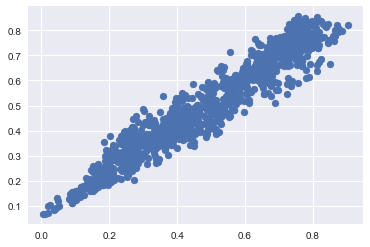

In [47]:
#real vs pred uniform scale

plt.scatter(test_class, y_pred)
plt.show()